In [1]:
%config InlineBackend.figure_format = 'svg'

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from cycler import cycler
import seaborn as sns

colors = ["#00A6D6", "white", "#EC6842"]
tu_delft_diverging = LinearSegmentedColormap.from_list("tu_delft_diverging", colors)
tu_delft_qualitative = ListedColormap(
    [
        "#0076C2",
        "#EC6842",
        "#00B8C8",
        "#FFB81C",
        "#0C2340",
        "#009B77",
        "#6F1D77",
        "#A50034",
        "#E03C31",
    ],
    name="tu_delft_qualitative",
)
mpl.colormaps.register(cmap=tu_delft_diverging)
mpl.colormaps.register(cmap=tu_delft_qualitative)
sns.set_palette(tu_delft_qualitative.colors)
plt.rc('axes', prop_cycle=cycler(color=tu_delft_qualitative.colors))
plt.rcParams.update({
    "figure.facecolor":  "None",
    "axes.facecolor":    "None",
    "savefig.facecolor": "None",
})

In [3]:
import numpy as np
import scipy.stats as stats
from myst_nb import glue

# Monte Carlo methods

## What approximating integrals has to do with stochastic modeling

Many applications of stochastic modeling in engineering require us to evaluate integrals of probability density functions.
Think for example of a temperature forecast – maybe you would like to know the expected value and the variance of the predicted temperature. Recall that both (expectation and variance) of a random variable (in this case temperature) are defined by an integral.
Or, you are making flood predictions and want to evaluate the exceedance probability for a certain water height. Again, the exceedance probability is defined as an integral.
In addition, obtaining marginal distributions from a joint distribution of two random variables also requires integration.

If the variables we are interested in can be described by simple and well-characterized parametric probability distributions (e.g., the Gaussian distribution), the integrals can be evaluated analytically.

Real-world models, however, are often more complex.
Many of the variables we are interested in can then not be described by simple parametric distributions.
In fact, we often have no idea what the distributions of model outputs look like, particularly for non-linear models.
In addition, models are often multi-dimensional.
In these cases, the integrals we are interested in cannot be evaluated analytically.
Instead, we need to evaluate them numerically.
In a single dimension, this can be done using "conventional" numerical integration techniques like quadrature rules.
For example, we could evaluate the function on a regular grid and integrate numerically using the trapezoidal rule.
However, this quickly becomes very inefficient in higher dimensions.

Instead of using points on a pre-defined geometry, we can also use random samples to approximate the integral.
This approach is called *Monte Carlo integration*.
It can feel very intuitive because it mirrors how we are used to think about probability distributions.
For example, think about how we approximate the expected value of a distribution by calculating the mean value of a set of samples.
This is exactly how a Monte Carlo estimate of the expected value would work: First, generate a set of random samples from your probability density function, then compute the average of these samples.

The next section looks in more detail in how we approximate integrals with Monte Carlo estimators.
The remaining part of this chapter then focuses on the first step: How we can generate samples from the probability density function we are interested in.



## Monte Carlo estimator

Monte Carlo methods are particularly suitable for evaluating expected values of random variables.
That is, we can approximate integrals of the following form:

$$F = \int_{-\infty}^{\infty} f(x) p(x) dx$$

where $p(x)$ is the probability density function associated with a random variable $X$, and $f(x)$ is a function.
Note that most of the integrals we are interested in (e.g., variance, expectation, cumulative probabilities) can be written in this form when we choose an appropriate function $f$.

The Monte Carlo estimator $\hat{F}$ of the integral $F$ is:

$$\hat{F} = \frac{1}{N} \sum_{i}^N f(X_i)$$

where $X_i$ are independent random variables distributed according to $p(x)$.
In practice, we generate realizations $x_i$ from this distribution and evaluate the estimator using these sample values.
That is, we evaluate the function $f$ for each of the random samples and average the result.

### Unbiasedness

A nice property of the Monte Carlo estimator is that it is unbiased, i.e., the expectation of the Monte Carlo estimator equals the true integral:

$$\mathbb{E}[\hat{F}] = F$$

`````{admonition} Proof
:class: tip, dropdown

$$
\begin{aligned}
\mathbb{E}[\hat{F}] &= \mathbb{E}\left[\frac{1}{N} \sum_{i=1}^{N} f(X_i)\right]\\
&= \frac{1}{N} \sum_{i=1}^{N} \mathbb{E}[f(X_i)]\\
&= \mathbb{E}[f(X)]\\
&= \int_{-\infty}^{\infty} f(x) p(x) dx\\
&= F
\end{aligned}
$$

`````

### Error and convergence

Even though the Monte Carlo estimator is unbiased, it always has an error because we can only generate a finite number fo samples.
The variance of the Monte Carlo estimator is:

$$\operatorname{Var}[\hat{F}] = \frac{1}{N} \operatorname{Var}[f(X)]$$

The corresponding standard error (i.e., the standard deviation of the estimator) is:

$$\operatorname{SE}[\hat{F}] = \frac{1}{\sqrt{N}} \sqrt{\operatorname{Var}[f(X)]}$$

That is, the standard error of decreases with the square root of the number of samples.
For example, improving the accuracy of the estimator by a factor of 10 requires 100 times more samples.
Even though Monte Carlo integration is much more efficient than other numerical integration techniques, the convergence rate is still kind of slow.

## Generating samples


### Transformations of a random variable


- Consider two random variables. The second variable is obtained by transforming the first one.
- if we have samples from one distribution, we can obtain samples from the second one by applying the transformation to each sample


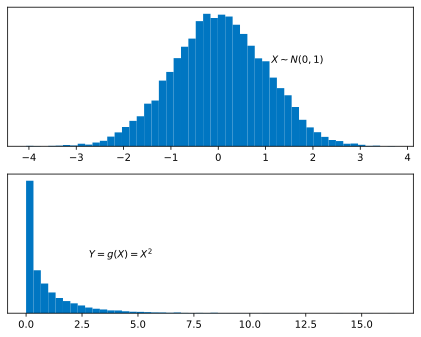

In [4]:
samples = stats.norm(0, 1).rvs(10000)
transformed = samples**2
fig, axs = plt.subplots(2, 1)
axs[0].hist(samples, bins=50)
axs[0].text(s=r"$X \sim N(0, 1)$", x=0.65, y=0.6, transform = axs[0].transAxes)
axs[1].hist(transformed, bins=50)
axs[1].text(s="$Y = g(X) = X^{2}$", x=0.2, y=0.4, transform = axs[1].transAxes)
plt.tight_layout()
for a in axs.flat:
    a.set_yticks([])
glue("transform_samples_fig", plt.gcf(), display=False)

```{glue:figure} transform_samples_fig
:width: 100%
:name: "fig-transform-samples"

This is a **caption**.
```


### Inverse sampling

We can use this trick of transforming samples to generate samples from a large class of parametric distributions if we consider a special type of transformation: the inverse cumulative distribution function. Hereby, we can leverage the fact that the cumulative distribution function of any random variable is uniformly distributed.

Consider that you want to generate samples of a random variable $X$ with probability density function $f(x)$.
Further assume that the cumulative density function (CDF) $F(x)$ has a closed form solution and is invertible.
Last but not least, you are also able to generate samples from a uniform distribution.

In that case, we can generate samples from $X$ as follows:

1. Derive an expression for the inverse CDF (also called *quantile function*), $F^{-1}(u)$.
2. Draw random samples $u_i$ from a uniform distribution on the interval $(0, 1)$.
3. Generate samples $x_i$ as $x_i = F^{-1}(u_i)$

This method is used in Scipy to generate samples for many of the parametric distributions.
It is very useful but also has its limitations: It can only be applied for distributions with invertible CDF, and mostly for a single dimension.

#### Example

Consider the Gumbel distribution (see {numref}`fig-inverse-sampling`). It's CDF is:

$$u = F(x) = \mathrm{e}^{-\mathrm{e}^{-\frac{x-\mu}{\beta}}}$$

We can solve this expression for $x$ to obtain the inverse distribution function:

$$x = F^{-1}(u) = \mu - \beta \ln(-\ln(u))$$

Now we draw samples from a uniform distribution:


In [23]:
import numpy as np
import scipy.stats as stats

u = stats.uniform.rvs(size=5)
print(f"u = {u}")


u = [0.03448245 0.38399244 0.63192895 0.5084177  0.72552692]


Then we plug in the values $u_i$ into the inverse distribution function (here using $\mu=0$ and $\beta=1$):

In [6]:
x = -np.log(-np.log(u))
print(f"x = {x}")

x = [ 0.47403197 -1.46056699 -0.5428876   0.40836327  1.36741053]


The generated samples are from the Gumbel distribution.

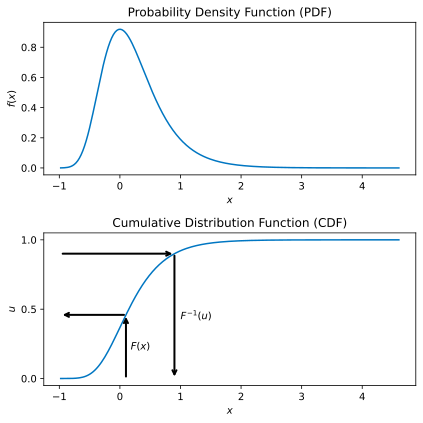

In [7]:
dist = stats.gumbel_r(scale=0.4)

alpha = 1e-5
x = np.linspace(dist.ppf(alpha), dist.ppf(1-alpha), num=200)
u = dist.cdf(x)
p = dist.pdf(x)

# Set up the subplot figure for PDF and CDF side by side
fig, ax = plt.subplots(2, 1, figsize=(6, 6))

# Left subplot: PDF
ax[0].plot(x, p)
ax[0].set_xlabel("$x$")
ax[0].set_ylabel(r"$f(x)$")
ax[0].set_title("Probability Density Function (PDF)")

# Right subplot: CDF with transformation arrows
ax[1].plot(x, u)
ax[1].set_xlabel("$x$")
ax[1].set_ylabel(r"$u$")
ax[1].set_title("Cumulative Distribution Function (CDF)")

# Annotate transformation from x to F(x)
x_value = 0.1  # Example x-value for arrow
u_value = dist.cdf(x_value)

ax[1].annotate(
    "",
    xy=(x_value, u_value),
    xytext=(x_value, 0),
    arrowprops=dict(arrowstyle="->", color="black", lw=2),
)
ax[1].annotate(
    "",
    xytext=(x_value, u_value),
    xy=(x[0], u_value),
    arrowprops=dict(arrowstyle="->", color="black", lw=2),
)
ax[1].text(x_value + 0.4, u_value / 2, "$F(x)$", ha="right", va="center", color="black")
plt.yticks([0, 0.5, 1])

# Annotate transformation from u to F(u)
u_value = 0.9  # Example x-value for arrow
x_value = dist.ppf(u_value)

ax[1].annotate(
    "",
    xytext=(x_value, u_value),
    xy=(x_value, 0),
    arrowprops=dict(arrowstyle="->", color="black", lw=2),
)
ax[1].annotate(
    "",
    xy=(x_value, u_value),
    xytext=(x[0], u_value),
    arrowprops=dict(arrowstyle="->", color="black", lw=2),
)
ax[1].text(
    x_value + 0.1, u_value / 2, "$F^{-1}(u)$", ha="left", va="center", color="black"
)
plt.yticks([0, 0.5, 1])

fig.tight_layout()

glue("inverse_sampling_fig", fig, display=False)

```{glue:figure} inverse_sampling_fig
:width: 80%
:name: "fig-inverse-sampling"

Inverse sampling illustrated at the example of the Gumble distribution. The CDF (lower panel) maps values from $x$ to probabilities in the interval $(0, 1)$.
We can invert this process by generating samples from a uniform distribution and applying the inverse CDF $F^{-1}(u)$.
```

#### Interactive Animation


### Rejection sampling

The methods for generating samples that we covered so far a limited to some special cases where we have a considerable amount of pre-knowledge about the distribution we want to sample.
For many other applications, however, we need more general methods with less requirements. For example, 

A very simple, but more general method is rejection sampling. 
The general idea of rejection sampling is to first generate samples from a known distribution (the so-called *proposal distribution*) and then discard samples that do not conform with the distribution we are interested in (the *target distribution*).
This "correction" is done by comparing the PDF of the proposal distribution, $q(x)$, to the target PDF $p(x)$.

```{glue:figure} rejection_sampling_fig_1
:width: 150%
:name: "fig-rejection-sampling-1"
:figclass: margin

Proposal and target distribution.
```


In [8]:
# Define the target distribution
def evaluate_target_pdf(x):
    """Target distribution with two peaks."""
    return 0.3 * np.exp(-0.2 * (x - 2) ** 2) + 0.7 * np.exp(-0.2 * (x + 2) ** 2)


def evaluate_proposal_pdf(x):
    return proposal.pdf(x)


def get_proposal_samples(N):
    return proposal.rvs(N)

def rejection_sampling(N, evaluate_target_pdf, evaluate_proposal_pdf, get_proposal_samples):
    # Generate samples from the proposal distribution
    proposal_samples = get_proposal_samples(N)
    
    # Compute the target and proposal pdf for each sample
    target_pdf = evaluate_target_pdf(proposal_samples)
    proposal_pdf = evaluate_proposal_pdf(proposal_samples)
    
    # Compute the ratio of the pdfs
    ratio = target_pdf / proposal_pdf
    
    # Determine the scaling constant
    M = ratio.max()
    
    # Accept or reject samples based on the ratio of the pdfs
    u = stats.uniform.rvs(size=N)
    accept = u < ratio / M
    return proposal_samples, proposal_pdf, u, accept, M

In [9]:
N = 1000
proposal = stats.norm(loc=0, scale=3)
proposal_samples, proposal_pdf, u, accept, M = rejection_sampling(
    N, evaluate_target_pdf, evaluate_proposal_pdf, get_proposal_samples
)

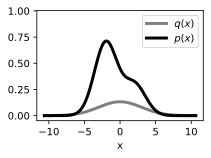

In [10]:
fig, axs = plt.subplots(1, figsize=(3, 2))
x_lim = np.max(np.abs(proposal_samples))
x = np.linspace(-x_lim, x_lim, 500)
plt.plot(x, evaluate_proposal_pdf(x) * M, lw=3, color="grey", alpha=0)
plt.plot(x, evaluate_proposal_pdf(x), label="$q(x)$", lw=3, color="grey",)
plt.plot(x, evaluate_target_pdf(x), label="$p(x)$", lw=3, color="k")
plt.legend()
plt.xlabel("x")
glue("rejection_sampling_fig_1", fig, display=False)

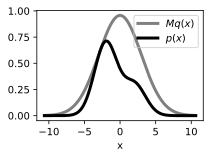

In [11]:
fig, axs = plt.subplots(1, figsize=(3, 2))
x_lim = np.max(np.abs(proposal_samples))
x = np.linspace(-x_lim, x_lim, 500)
plt.plot(x, evaluate_proposal_pdf(x) * M, label="$M q(x)$", lw=3, color="grey",)
plt.plot(x, evaluate_target_pdf(x), label="$p(x)$", lw=3, color="k")
plt.legend()
plt.xlabel("x")
glue("rejection_sampling_fig_2", fig, display=False)

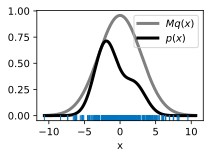

In [18]:
fig, axs = plt.subplots(1, figsize=(3, 2))
plt.plot(x, evaluate_proposal_pdf(x) * M, label="$M q(x)$", lw=3, color="grey",)
plt.plot(x, evaluate_target_pdf(x), label="$p(x)$", lw=3, color="k")
sns.rugplot(proposal_samples[::3], expand_margins=False, height=0.05)
plt.legend()
plt.xlabel("x")
glue("rejection_sampling_fig_3", fig, display=False)


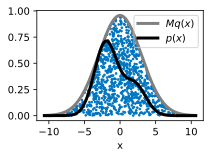

In [22]:
fig, axs = plt.subplots(1, figsize=(3, 2))
plt.plot(x, evaluate_proposal_pdf(x) * M, label="$M q(x)$", lw=3, color="grey",)
plt.plot(x, evaluate_target_pdf(x), label="$p(x)$", lw=3, color="k")
plt.scatter(
    proposal_samples,
    M * proposal_pdf * u,
    color="C0",
    s=3,
)
plt.legend()
plt.xlabel("x")
glue("rejection_sampling_fig_4", plt.gcf(), display=False)

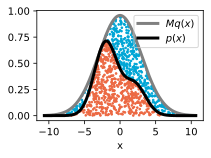

In [14]:
fig, axs = plt.subplots(1, figsize=(3, 2))
plt.plot(x, evaluate_proposal_pdf(x) * M, label="$M q(x)$", lw=3, color="grey",)
plt.plot(x, evaluate_target_pdf(x), label="$p(x)$", lw=3, color="k")
plt.scatter(
    proposal_samples,
    M * proposal_pdf * u,
    c=accept,
    s=3,
    cmap="tu_delft_diverging"
)
plt.legend()
plt.xlabel("x")
glue("rejection_sampling_fig_5", plt.gcf(), display=False)


#### Algorithm

1. Define a proposal distribution with density $q(x)$ ({numref}`fig-rejection-sampling-1`).
   
   In principal, we can freely choose this density, but there are two important requirements: It should be defined over the same range of $x$ values as $p(x)$, and we need to be able to generate samples from this distribution.
   Later on, you will also see that it is beneficial if $q(x)$ resembles $p(x)$ as much as possible.

```{glue:figure} rejection_sampling_fig_2
:width: 150%
:name: "fig-rejection-sampling-2"
:figclass: margin

Scaling the proposal distribution.
```

2. Scale the proposal density such that is always larger than the target density ({numref}`fig-rejection-sampling-2`).

   That is, we define a scaling constant $M$ so that

   $$\quad Mq(x) \geq p(x) \quad \forall x$$

   In practice, determining the scaling constant $M$ is a bit tricky because we do not know the target PDF globally. We can only evaluate it at individual points.
   Therefore, in practice, this condition is loosened, only requiring that it is fulfilled for all samples $x_i$ that we generate in the next step.

```{glue:figure} rejection_sampling_fig_3
:width: 150%
:name: "fig-rejection-sampling-3"
:figclass: margin

Sampling the proposal distribution.
```

3. Generate a samples from the proposal distribution.

   That is, we obtain samples $x_i$ from $X \sim q(x)$. In ({numref}`fig-rejection-sampling-3`), these samples are indicated as small blue bars on the $x$-axis.

```{glue:figure} rejection_sampling_fig_4
:width: 150%
:name: "fig-rejection-sampling-4"
:figclass: margin

Sampling a uniform distribution.
```

4. Sample $U_i \sim \text{Uniform}(0, M q(x_i))$.

   For each sample $x_i$ we draw one sample $u_i$ from a uniform distribution $U_i$ zero to the value of the scaled proposal distribution at $x_i$.
   In ({numref}`fig-rejection-sampling-4`), each $u_i$ is plotted against the corresponding $x_i$.
   In this way, we generate dots that cover the area below the proposal distribution.

```{glue:figure} rejection_sampling_fig_5
:width: 150%
:name: "fig-rejection-sampling-5"
:figclass: margin

Rejecting samples.
```

5. Accept $x_i$ if $u_i \leq p(x_i)$. Otherwise, reject.

   Visually, we accept all samples that fall under the curve of the target distribution (colored orange in {numref}`fig-rejection-sampling-5`).
   Samples that fall in the area between the target and the proposal distribution are rejected.


#### Limitations


Rejection sampling is a simple algorithm but it quickly becomes becomes very inefficient.

This is true particularly when the proposal distribution does not approximate the target distribution well.
Visually, this means that the overlap between the two distributions will be very small.
Then, most of the samples that we generate will fall in the area between the two curves instead of under the curve of the target distribution.
Therefore, most samples that we generate will be rejected.

Rejection sampling also becomes inefficient in higher dimensions.
The fraction of samples that we accept corresponds to the area under the target distribution compared to the area under the proposal distribution.
In higher dimension, instead of an area, we will have to look at a volume.
The volume in between the two distributions grows much faster with the number of dimensions than the volume "inside" the target distribution.
This means that with increasing number of dimensions, the fraction of accepted samples gets smaller and smaller.
This is also referred to as the *curse of dimensionality*-

### Importance sampling